This project tackles the task of image captioning, a field at the intersection of computer vision and natural language processing. We'll build a modern architecture using a `Vision Transformer (ViT)` to encode images and a `BERT-based` model to decode them into descriptive text. The entire model will be trained and evaluated on the `Flickr 8k` dataset with the goal of generating accurate, human-like captions for unseen images.

All training will be performed on `Nvidia A100` in `Google Colab`.

First we need to install some extra libraries to use ROUGE as an evaluation metric.

In [ ]:
!pip install -q evaluate
!pip install -q rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sun Jun 15 02:06:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Let's download the data.

In [ ]:
import os
import kagglehub

path = kagglehub.dataset_download('adityajn105/flickr8k')

print(f'Path to dataset files: {path}')
print(f'Files and directories: {os.listdir(path)}')

Path to dataset files: /kaggle/input/flickr8k
Files and directories: ['captions.txt', 'Images']


In [ ]:
with open('/kaggle/input/flickr8k/captions.txt') as f:
    captions = f.read()

print(captions[:500])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3


The `captions.txt` file contains data in a valid CSV format, which we will load into a DataFrame. But first we'll look at the images.

In [ ]:
os.listdir('/kaggle/input/flickr8k/Images')[:5]

['3226254560_2f8ac147ea.jpg',
 '214543992_ce6c0d9f9b.jpg',
 '2366643786_9c9a830db8.jpg',
 '3368819708_0bfa0808f8.jpg',
 '2190227737_6e0bde2623.jpg']

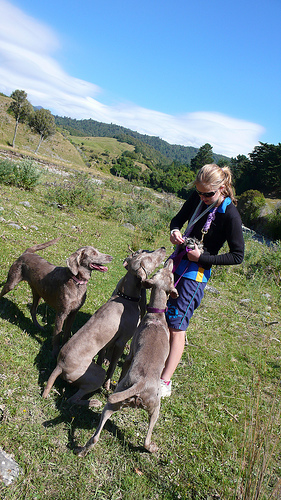

In [ ]:
from PIL import Image

Image.open('/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg')

Let's make a DataFrame with path to images and captions as columns.

In [ ]:
import io
import numpy as np
import pandas as pd

# Setting seed
np.random.seed(42)

# Load the captions string into a pandas DataFrame
buff = io.StringIO(captions)
df = pd.read_csv(buff)
# Construct the full path for each image file
df.image = df.image.apply (lambda im_path: os.path.join(path, 'Images', im_path))

df.head(10)

image  \
0  /kaggle/input/flickr8k/Images/1000268201_693b0...   
1  /kaggle/input/flickr8k/Images/1000268201_693b0...   
2  /kaggle/input/flickr8k/Images/1000268201_693b0...   
3  /kaggle/input/flickr8k/Images/1000268201_693b0...   
4  /kaggle/input/flickr8k/Images/1000268201_693b0...   
5  /kaggle/input/flickr8k/Images/1001773457_577c3...   
6  /kaggle/input/flickr8k/Images/1001773457_577c3...   
7  /kaggle/input/flickr8k/Images/1001773457_577c3...   
8  /kaggle/input/flickr8k/Images/1001773457_577c3...   
9  /kaggle/input/flickr8k/Images/1001773457_577c3...   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

It looks like there are a lot of duplicates in the dataset.

In [ ]:
df = df.sort_values('image').reset_index(drop=True)

df.head(12).image.values

array(['/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg',
       '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg'],
      dtype=object)

The dataset consists of 40455 images with captions, but only 8091 images are unique. It means that there are 5 different captions for each image.

We'll do the following:
- Set a random rank(1-5) for the image within its image group
- Marker each image that has the rank less than 5 as the one which will be used in the training process
- The rest of the images will be used for the test and validation sets

The distribution will look like this:
- 32364 for the train set
- 4046 for the test set
- 4045 for the validation set

In [ ]:
len(df), df.image.nunique(), 8091 // 2 + 1, 8091 // 2

(40455, 8091, 4046, 4045)

In [ ]:
df['random_rank'] = df.groupby('image').image.transform(
    lambda x: np.random.permutation(len(x))
)
df['is_train'] = df['random_rank'] < 4

df.head(12)

image  \
0   /kaggle/input/flickr8k/Images/1000268201_693b0...   
1   /kaggle/input/flickr8k/Images/1000268201_693b0...   
2   /kaggle/input/flickr8k/Images/1000268201_693b0...   
3   /kaggle/input/flickr8k/Images/1000268201_693b0...   
4   /kaggle/input/flickr8k/Images/1000268201_693b0...   
5   /kaggle/input/flickr8k/Images/1001773457_577c3...   
6   /kaggle/input/flickr8k/Images/1001773457_577c3...   
7   /kaggle/input/flickr8k/Images/1001773457_577c3...   
8   /kaggle/input/flickr8k/Images/1001773457_577c3...   
9   /kaggle/input/flickr8k/Images/1001773457_577c3...   
10  /kaggle/input/flickr8k/Images/1002674143_1b742...   
11  /kaggle/input/flickr8k/Images/1002674143_1b742...   

                                              caption  random_rank  is_train  
0   A child in a pink dress is climbing up a set o...            1      True  
1               A girl going into a wooden building .            4     False  
2    A little girl climbing into a wooden playhouse .            2      True  
3   A little girl climbing the stairs to her playh...            0      True  
4   A little girl in a pink dress going into a woo...            3      True  
5     Two dogs on pavement moving toward each other .            3      True  
6   A black dog and a white dog with brown spots a...            1      True  
7   Two dogs of different breeds looking at each o...            2      True  
8          A black dog and a spotted dog are fighting            0      True  
9   A black dog and a tri-colored dog playing with...            4     False  
10  A little girl covered in paint sits in front o...            1      True  
11  A little girl is sitting in front of a large p...            0      True

In [ ]:
# Check the number of samples in the train set
df.is_train.sum()

np.int64(32364)

In [ ]:
train_df = df[df.is_train]

res_df = df[~df.is_train]
res_df = res_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 4046
test_df = res_df.iloc[:test_size].reset_index(drop=True)
valid_df = res_df.iloc[test_size:].reset_index(drop=True)

# Check the distribution
len(train_df), len(test_df), len(valid_df)

(32364, 4046, 4045)

In [ ]:
import torch
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set()

**BERT Overview**

`BERT`, which stands for `Bidirectional Encoder Representations from Transformers`, is a powerful language model that learns to understand the context of words in text. It processes entire sequences of text at once, allowing it to grasp the meaning of a word based on both the words that come before and after it. `BERT` is pre-trained on a massive amount of text using two main tasks: predicting randomly hidden words in a sentence (Masked Language Model) and determining if one sentence logically follows another (Next Sentence Prediction). This deep, bidirectional pre-training enables `BERT` to be easily fine-tuned for a wide range of natural language processing tasks with high accuracy.

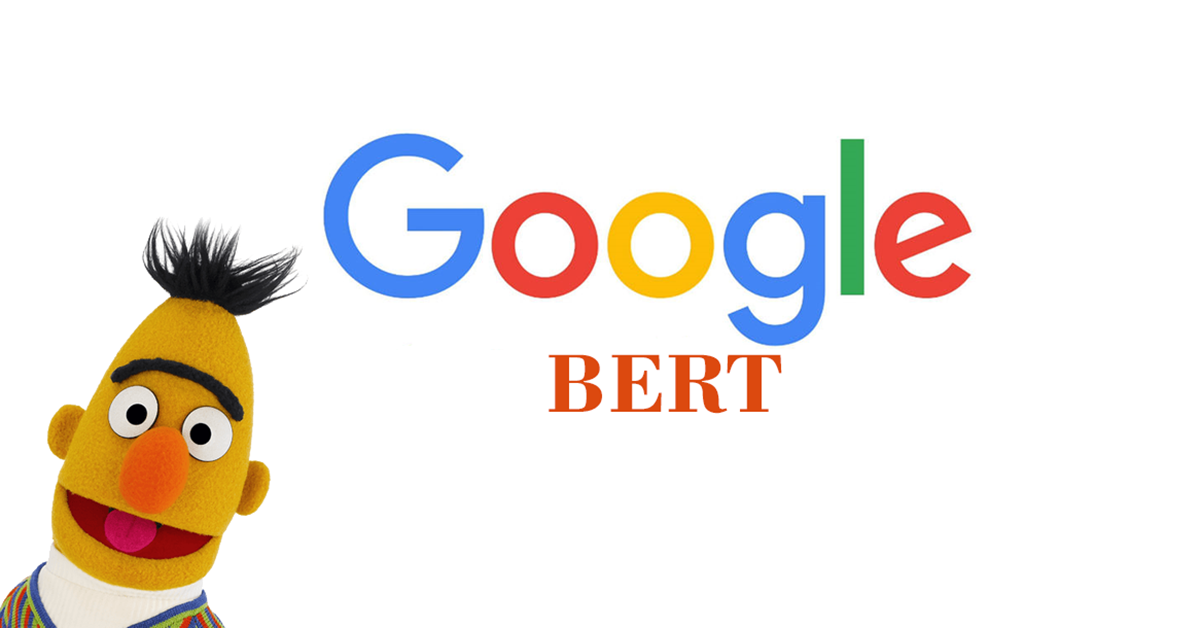

Let's analyze the captions to determine the maximum sequence length.

In [ ]:
from transformers import AutoTokenizer

llm_id = 'google-bert/bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(llm_id)

tokenizer.add_special_tokens({'pad_token': '[PAD]'})

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

0

In [ ]:
def get_num_tokens(text: str) -> int:
    return len(tokenizer(text)['input_ids'])

df['tokens_per_description'] = df.caption.map(get_num_tokens)

df.head()

image  \
0  /kaggle/input/flickr8k/Images/1000268201_693b0...   
1  /kaggle/input/flickr8k/Images/1000268201_693b0...   
2  /kaggle/input/flickr8k/Images/1000268201_693b0...   
3  /kaggle/input/flickr8k/Images/1000268201_693b0...   
4  /kaggle/input/flickr8k/Images/1000268201_693b0...   

                                             caption  random_rank  is_train  \
0  A child in a pink dress is climbing up a set o...            1      True   
1              A girl going into a wooden building .            4     False   
2   A little girl climbing into a wooden playhouse .            2      True   
3  A little girl climbing the stairs to her playh...            0      True   
4  A little girl in a pink dress going into a woo...            3      True   

   tokens_per_description  
0                      20  
1                      10  
2                      11  
3                      12  
4                      15

In [ ]:
df.tokens_per_description.max()

42

The longest caption is 42 tokens long. We'll save this value for later.

In [ ]:
from torch.utils.data import Dataset


class ImageCaptionDataset(Dataset):
    """Dataset that returns prcessed images with LVM processor and LLM tokenizer"""

    def __init__(self, df, processor, tokenizer, max_length=42):
        self.images = df.image.values.tolist()
        self.captions = df.caption.values.tolist()
        self.processor = processor
        self.tokenizer = tokenizer
        # Tokens from the text + [CLS] + [SEP] tokens
        self.max_length = max_length + 2

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Reading the image and getting pixel values
        image = Image.open(self.images[idx]).convert('RGB')
        im_inputs = self.processor(images=image, return_tensors='pt')
        pixel_values = im_inputs['pixel_values'].squeeze(0)

        # Tokenizing the caption and getting input ids
        caption = self.captions[idx]
        text_inputs = self.tokenizer(
            caption,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_length,
            truncation=True
        )

        input_ids = torch.tensor(text_inputs.input_ids)
        input_ids[input_ids == tokenizer.pad_token_id] = -100

        return pixel_values, input_ids

There are two important points to note about the code above:
- We set `max_length` 42 based on our analysis
- We replace all `input_ids` that are equal to BERT `[PAD]` token id with `-100` because torch uses this constant as the marker to ignore these specific tokens during loss calculation

Let's load our LVM(Google ViT) and then create the datasets.

In [ ]:
from transformers import AutoImageProcessor

lvm_id = 'google/vit-base-patch16-224-in21k'
processor = AutoImageProcessor.from_pretrained(lvm_id, use_fast=True)

train_ds = ImageCaptionDataset(train_df, processor, tokenizer)
test_ds = ImageCaptionDataset(test_df, processor, tokenizer)
valid_ds = ImageCaptionDataset(valid_df, processor, tokenizer)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

**Vision Transformer (ViT) Overview**

The `Vision Transformer (ViT)` is a seminal model that first demonstrated that a pure Transformer architecture, prevalent in natural language processing, could be directly applied to computer vision tasks with minimal modifications. It processes images by first splitting them into a sequence of fixed-size, non-overlapping patches, which are then flattened and linearly embedded into vectors. To retain positional information, learnable position embeddings are added to these patch embeddings, and the entire sequence is prepended with a special `[CLS]` token, whose corresponding output is used for classification. The model then feeds this sequence of vectors into a standard Transformer encoder, which applies global self-attention uniformly across all patches, allowing every patch to interact with every other patch from the very first layer. This straightforward approach of treating an image as a sequence of patches enables `ViT` to achieve remarkable performance, particularly when pre-trained on large datasets, establishing a new paradigm for computer vision models.

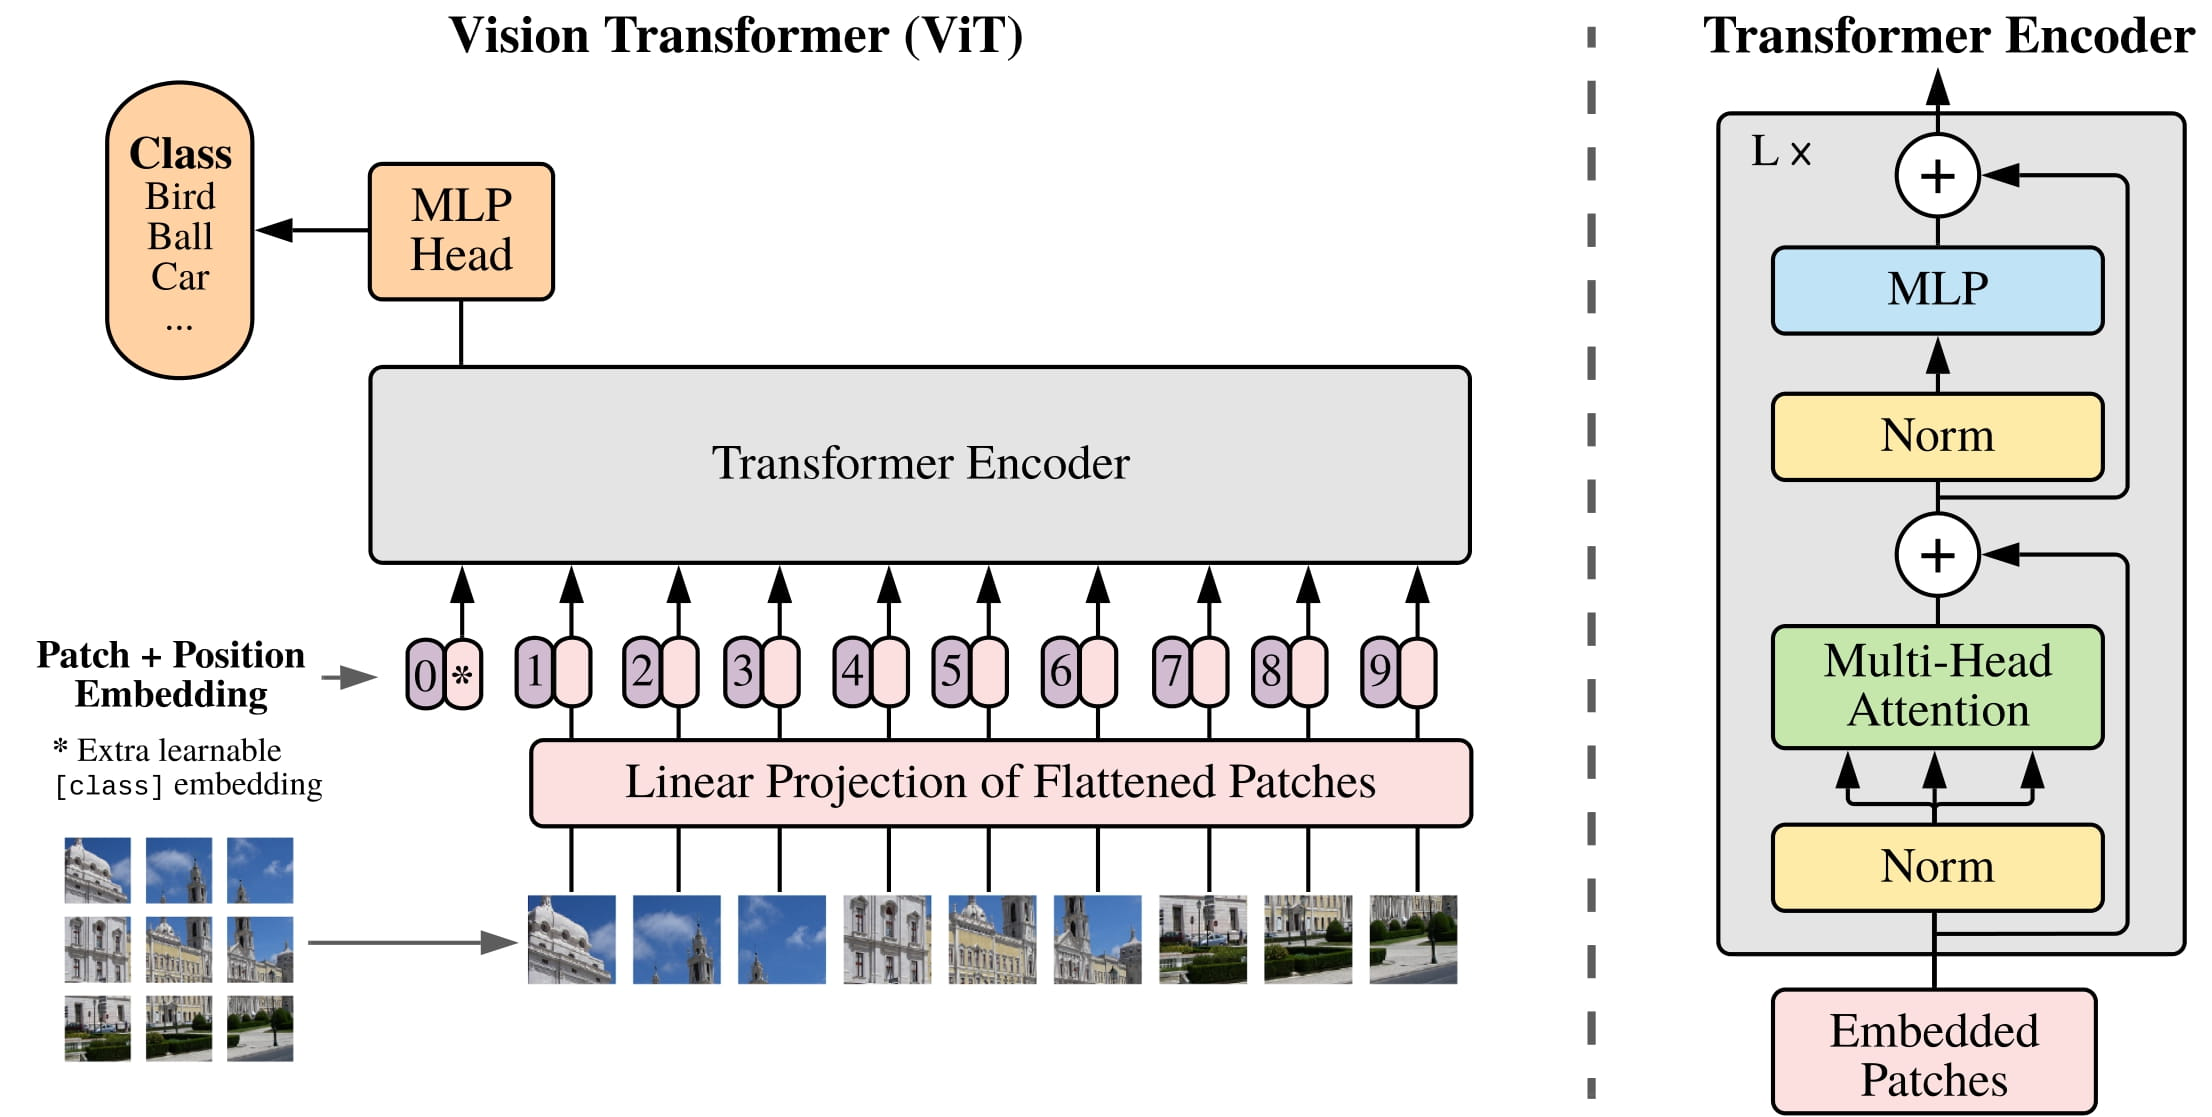

In [ ]:
# Verify the output of the dataset
train_ds[0]

(tensor([[[-0.3569, -0.1294, -0.0902,  ..., -0.9686, -0.9529, -0.9529],
          [-0.3804, -0.1137, -0.0667,  ..., -0.9373, -0.9451, -0.9059],
          [-0.3961, -0.0824, -0.0588,  ..., -0.9373, -0.9451, -0.9216],
          ...,
          [ 0.4588,  0.1765,  0.3412,  ...,  0.6627,  0.2941,  0.2941],
          [ 0.3882,  0.3961,  0.7255,  ...,  0.6392,  0.3176,  0.3176],
          [ 0.6235,  0.6392,  0.4667,  ...,  0.6078,  0.3098,  0.3255]],
 
         [[-0.3098,  0.0039,  0.0510,  ..., -0.9765, -0.9529, -0.9373],
          [-0.3412,  0.0118,  0.0824,  ..., -0.9294, -0.9216, -0.8353],
          [-0.3804,  0.0353,  0.1059,  ..., -0.9216, -0.8980, -0.8275],
          ...,
          [-0.1529, -0.3725, -0.0431,  ...,  0.7255,  0.4431,  0.4431],
          [-0.2471,  0.0118,  0.3255,  ...,  0.7098,  0.4431,  0.4431],
          [-0.0118,  0.1608, -0.0431,  ...,  0.6784,  0.4431,  0.4431]],
 
         [[-0.2392, -0.0196, -0.0039,  ..., -0.9765, -0.9686, -0.9608],
          [-0.2784,  0.0118,

The datasets are ready, now we need to define the dataloaders.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
cpu_count = os.cpu_count() # 12
params = dict(
    shuffle=True,
    batch_size=batch_size,
    num_workers=cpu_count,
    pin_memory=True
)

train_dl = DataLoader(train_ds, **params)
test_dl = DataLoader(test_ds, **params)
valid_dl = DataLoader(valid_ds, **params)

In the code above, we set up parallel processing for data loading by setting `num_workers` to the number of available CPU cores, which helps speed things up. We also optimized data transfer from the CPU to the GPU by setting `pin_memory` to `True`.

Now we need to download the full model.

In [ ]:
from transformers import VisionEncoderDecoderModel


model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(lvm_id, llm_id)

# ids
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bi

In [ ]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (inte

We have the data loaders and the model. Now, we need to define the remaining training components, such as the optimizer, number of training epochs, learning rate scheduler, compute device, and the `ROUGE score` for our evaluation metric.

In [ ]:
import evaluate
from torch.optim import AdamW
from transformers import get_scheduler

epochs = 30
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = epochs * len(train_dl)
num_warmup_steps = num_training_steps // 5

scheduler = get_scheduler(name='linear', optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

metric = evaluate.load('rouge')

Everything is set up, now we may implement some extra functions for the training process.

In [ ]:
from tqdm import tqdm

def evaluate_with_rouge(model, dl, tokenizer, metric, device):
    """
     Method to evaluate model's performance on a given dataset using the ROUGE metric

    :param model: The model to evaluate
    :param dl: The DataLoader for the evaluation data
    :param tokenizer: The tokenizer used to decode predictions and labels
    :param metric: The ROUGE metric object from the `evaluate` library
    :param device: The device (CPU or CUDA) for evaluation
    :return: A dictionary with the computed metrics: rouge1, rouge2, rougeL and rougeLsum
    """
    model.eval()

    progress_bar = tqdm(dl, desc='Calculating Rouge', leave=False)

    for pixel_values, input_ids in progress_bar:
        pixel_values = pixel_values.to(device)
        labels = input_ids.to(device)

        # Disable gradient calculation for faster and less memory-intensive inference
        with torch.no_grad():
            outputs = model(
                pixel_values=pixel_values,
                labels=labels
            )

        # Get the most likely token ID for each position in the sequence
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Decode the predicted token IDs into text
        predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        # Minor cleanup on the predictions to improve scoring alignment
        predictions = [pred_caption.replace('.', '') for pred_caption in predictions]
        # Labels use -100 to mask padding, replace with [PAD] token id for correct decoding
        references = [
            tokenizer.decode(
                [tokenizer.pad_token_id if token == -100 else token for token in reference],
                skip_special_tokens=True
            )
            for reference in labels.tolist()
        ]
        # Add the current batch of predictions and references to the metric accumulator
        metric.add_batch(predictions=predictions, references=references)

    return metric.compute()

In [ ]:
def train_one_epoch(model, dl, optimizer, scheduler, device, tokenizer, metric):
    """
    Function that trains the model for a single epoch

    :param model: The model to be trained
    :param dl: DataLoader for the training data
    :param optimizer: The optimizer for updating model weights
    :param scheduler: The learning rate scheduler
    :param device: The device for training
    :param tokenizer: BERT tokenizer for decoding
    :param metric: The metric object to evaluate rouge1, rouge2, rougeL and rougeLsum
    :return: A dictionary with loss and computed metrics: rouge1, rouge2, rougeL and rougeLsum
    """
    model.train()

    total_loss = 0
    progress_bar = tqdm(dl, desc='Training', leave=False)

    for pixel_values, input_ids in progress_bar:
        # Move data to the specified computation device.
        pixel_values = pixel_values.to(device)
        labels = input_ids.to(device)

        # Perform a forward pass through the model.
        # The model returns outputs including the loss.
        outputs = model(
            pixel_values=pixel_values,
            labels=labels
        )
        loss = outputs.loss

        # Backpropagation: compute gradients, update weights, and clear gradients.
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update the progress bar with the loss for the current batch.
        progress_bar.set_postfix(loss=loss.item())

        total_loss += loss.item()

    # Calculate the average loss over all batches.
    avg_loss = total_loss / len(dl)

    # Evaluate the model on the training data at the end of the epoch.
    rouge_scores = evaluate_with_rouge(model, dl, tokenizer, metric, device)

    return {'loss': avg_loss, **rouge_scores}

In [ ]:
def evaluate(model, dl, device, tokenizer, metric):
    """
    Method to evaluate the model on a given dataset

    :param model: The model to evaluate
    :param dl: DataLoader for the evaluation data
    :param device: The device for evaluation
    :param tokenizer: BERT tokenizer for decoding predictions
    :param metric: The metric object to evaluate rouge1, rouge2, rougeL and rougeLsum
    :return: A dictionary with loss and computed metrics: rouge1, rouge2, rougeL and rougeLsum
    """
    model.eval()

    total_loss = 0
    progress_bar = tqdm(dl, desc='Evaluating', leave=False)

    for pixel_values, input_ids in progress_bar:
        pixel_values = pixel_values.to(device)
        labels = input_ids.to(device)

        # Disable gradient calculation for inference.
        with torch.no_grad():
            outputs = model(
                pixel_values=pixel_values,
                labels=labels
            )

        # Accumulate the loss for the batch.
        loss = outputs.loss
        total_loss += loss.item()

        # Update the progress bar with the current batch's loss.
        progress_bar.set_postfix(loss=loss.item())

    # Calculate the average loss across all batches.
    avg_loss = total_loss / len(dl)

    # Use the separate function to get ROUGE scores for the whole dataset.
    rouge_scores = evaluate_with_rouge(model, dl, tokenizer, metric, device)

    # Return a dictionary with the average loss and the ROUGE scores.
    return {'loss': avg_loss, **rouge_scores}

In [ ]:
class History:
    """Plcaholder to store training metrics and loss in a structured format"""

    def __init__(self):
        self._history = {'loss': [], 'rouge1': [], 'rouge2': [], 'rougeL': [], 'rougeLsum': []}

    def update(self, metrics):
        self._history ['loss'].append(metrics.get('loss', 0.0))
        self._history ['rouge1'].append(metrics.get('rouge1', 0.0))
        self._history ['rouge2'].append(metrics.get('rouge2', 0.0))
        self._history ['rougeL'].append(metrics.get('rougeL', 0.0))
        self._history ['rougeLsum'].append(metrics.get('rougeLsum', 0.0))

    def to_df(self):
        return pd.DataFrame(self._history)

    @property
    def hist_metrics(self):
        return self._history

We have all necessary stuff to start the training. So, let's do it!

In [ ]:
train_history = History()
test_history = History()

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')

    train_metrics = train_one_epoch(model, train_dl, optimizer, scheduler, device, tokenizer, metric)
    test_metrics = evaluate(model, test_dl, device, tokenizer, metric)

    print(f"Train | Loss: {train_metrics['loss']:.3f} | Rouge1: {train_metrics['rouge1']:.5f} | Rouge2: {train_metrics['rouge2']:.5f} | RougeL: {train_metrics['rougeL']:.5f} | RougeLsum: {train_metrics['rougeLsum']:.5f}")
    print(f" Test | Loss: {test_metrics['loss']:.3f} | Rouge1: {test_metrics['rouge1']:.5f} | Rouge2: {test_metrics['rouge2']:.5f} | RougeL: {test_metrics['rougeL']:.5f} | RougeLsum: {test_metrics['rougeLsum']:.5f}\n")

    train_history.update(train_metrics)
    test_history.update(test_metrics)

    model.save_pretrained(f'model_epoch_{epoch}')

Epoch 1/30


Training:   0%|          | 0/1012 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Train | Loss: 6.044 | Rouge1: 0.24288 | Rouge2: 0.02168 | RougeL: 0.23051 | RougeLsum: 0.23056
 Test | Loss: 4.467 | Rouge1: 0.24560 | Rouge2: 0.02098 | RougeL: 0.23373 | RougeLsum: 0.23387

Epoch 2/30


Train | Loss: 4.124 | Rouge1: 0.30029 | Rouge2: 0.05669 | RougeL: 0.25042 | RougeLsum: 0.25041
 Test | Loss: 3.768 | Rouge1: 0.29860 | Rouge2: 0.05539 | RougeL: 0.24923 | RougeLsum: 0.24920

Epoch 3/30


Train | Loss: 3.597 | Rouge1: 0.31271 | Rouge2: 0.07167 | RougeL: 0.26260 | RougeLsum: 0.26260
 Test | Loss: 3.474 | Rouge1: 0.30487 | Rouge2: 0.06716 | RougeL: 0.25740 | RougeLsum: 0.25739

Epoch 4/30


Train | Loss: 3.277 | Rouge1: 0.30555 | Rouge2: 0.08191 | RougeL: 0.25649 | RougeLsum: 0.25650
 Test | Loss: 3.331 | Rouge1: 0.29015 | Rouge2: 0.07217 | RougeL: 0.24278 | RougeLsum: 0.24267

Epoch 5/30


Train | Loss: 3.017 | Rouge1: 0.32724 | Rouge2: 0.10666 | RougeL: 0.29795 | RougeLsum: 0.29796
 Test | Loss: 3.081 | Rouge1: 0.29986 | Rouge2: 0.08965 | RougeL: 0.27314 | RougeLsum: 0.27307

Epoch 6/30


Train | Loss: 2.783 | Rouge1: 0.31040 | Rouge2: 0.11018 | RougeL: 0.27890 | RougeLsum: 0.27882
 Test | Loss: 3.017 | Rouge1: 0.27443 | Rouge2: 0.08530 | RougeL: 0.24570 | RougeLsum: 0.24580

Epoch 7/30


Train | Loss: 2.565 | Rouge1: 0.40188 | Rouge2: 0.16115 | RougeL: 0.37127 | RougeLsum: 0.37127
 Test | Loss: 2.978 | Rouge1: 0.34129 | Rouge2: 0.11158 | RougeL: 0.31330 | RougeLsum: 0.31300

Epoch 8/30


Train | Loss: 2.325 | Rouge1: 0.36335 | Rouge2: 0.15278 | RougeL: 0.33164 | RougeLsum: 0.33165
 Test | Loss: 3.003 | Rouge1: 0.28772 | Rouge2: 0.09061 | RougeL: 0.25928 | RougeLsum: 0.25912

Epoch 9/30


Train | Loss: 2.098 | Rouge1: 0.38403 | Rouge2: 0.17828 | RougeL: 0.35242 | RougeLsum: 0.35244
 Test | Loss: 3.049 | Rouge1: 0.28658 | Rouge2: 0.08817 | RougeL: 0.25629 | RougeLsum: 0.25645

Epoch 10/30


Train | Loss: 1.879 | Rouge1: 0.42256 | Rouge2: 0.21812 | RougeL: 0.39542 | RougeLsum: 0.39536
 Test | Loss: 3.134 | Rouge1: 0.29755 | Rouge2: 0.09420 | RougeL: 0.26815 | RougeLsum: 0.26836

Epoch 11/30


Train | Loss: 1.674 | Rouge1: 0.46482 | Rouge2: 0.26420 | RougeL: 0.43861 | RougeLsum: 0.43854
 Test | Loss: 3.223 | Rouge1: 0.30801 | Rouge2: 0.09843 | RougeL: 0.27755 | RougeLsum: 0.27763

Epoch 12/30


Train | Loss: 1.488 | Rouge1: 0.47808 | Rouge2: 0.29968 | RougeL: 0.45568 | RougeLsum: 0.45572
 Test | Loss: 3.302 | Rouge1: 0.29705 | Rouge2: 0.09373 | RougeL: 0.26689 | RougeLsum: 0.26669

Epoch 13/30


Train | Loss: 1.320 | Rouge1: 0.43381 | Rouge2: 0.28878 | RougeL: 0.41438 | RougeLsum: 0.41437
 Test | Loss: 3.413 | Rouge1: 0.26187 | Rouge2: 0.08040 | RougeL: 0.23220 | RougeLsum: 0.23219

Epoch 14/30


Train | Loss: 1.176 | Rouge1: 0.57677 | Rouge2: 0.41128 | RougeL: 0.55881 | RougeLsum: 0.55870
 Test | Loss: 3.557 | Rouge1: 0.33286 | Rouge2: 0.10510 | RougeL: 0.29878 | RougeLsum: 0.29882

Epoch 15/30


Train | Loss: 1.046 | Rouge1: 0.53814 | Rouge2: 0.40041 | RougeL: 0.52122 | RougeLsum: 0.52114
 Test | Loss: 3.665 | Rouge1: 0.29938 | Rouge2: 0.09183 | RougeL: 0.26611 | RougeLsum: 0.26612

Epoch 16/30


Train | Loss: 0.936 | Rouge1: 0.57989 | Rouge2: 0.44799 | RougeL: 0.56513 | RougeLsum: 0.56504
 Test | Loss: 3.762 | Rouge1: 0.31520 | Rouge2: 0.09719 | RougeL: 0.28110 | RougeLsum: 0.28107

Epoch 17/30


Train | Loss: 0.842 | Rouge1: 0.56992 | Rouge2: 0.45235 | RougeL: 0.55677 | RougeLsum: 0.55681
 Test | Loss: 3.880 | Rouge1: 0.30050 | Rouge2: 0.09277 | RougeL: 0.26686 | RougeLsum: 0.26680

Epoch 18/30


Train | Loss: 0.764 | Rouge1: 0.56433 | Rouge2: 0.45441 | RougeL: 0.55159 | RougeLsum: 0.55167
 Test | Loss: 3.999 | Rouge1: 0.29195 | Rouge2: 0.08975 | RougeL: 0.25926 | RougeLsum: 0.25924

Epoch 19/30


Train | Loss: 0.699 | Rouge1: 0.52404 | Rouge2: 0.42765 | RougeL: 0.51276 | RougeLsum: 0.51279
 Test | Loss: 4.105 | Rouge1: 0.27156 | Rouge2: 0.08318 | RougeL: 0.23986 | RougeLsum: 0.23993

Epoch 20/30


Train | Loss: 0.641 | Rouge1: 0.52616 | Rouge2: 0.43259 | RougeL: 0.51570 | RougeLsum: 0.51567
 Test | Loss: 4.174 | Rouge1: 0.27258 | Rouge2: 0.08105 | RougeL: 0.24105 | RougeLsum: 0.24124

Epoch 21/30


Train | Loss: 0.591 | Rouge1: 0.64368 | Rouge2: 0.53955 | RougeL: 0.63282 | RougeLsum: 0.63291
 Test | Loss: 4.279 | Rouge1: 0.32143 | Rouge2: 0.09815 | RougeL: 0.28660 | RougeLsum: 0.28656

Epoch 22/30


Train | Loss: 0.550 | Rouge1: 0.60534 | Rouge2: 0.50885 | RougeL: 0.59536 | RougeLsum: 0.59543
 Test | Loss: 4.349 | Rouge1: 0.30225 | Rouge2: 0.09067 | RougeL: 0.26902 | RougeLsum: 0.26891

Epoch 23/30


Train | Loss: 0.514 | Rouge1: 0.60664 | Rouge2: 0.51215 | RougeL: 0.59714 | RougeLsum: 0.59702
 Test | Loss: 4.418 | Rouge1: 0.29978 | Rouge2: 0.08996 | RougeL: 0.26694 | RougeLsum: 0.26679

Epoch 24/30


Train | Loss: 0.482 | Rouge1: 0.58653 | Rouge2: 0.49567 | RougeL: 0.57694 | RougeLsum: 0.57703
 Test | Loss: 4.490 | Rouge1: 0.28818 | Rouge2: 0.08608 | RougeL: 0.25510 | RougeLsum: 0.25518

Epoch 25/30


Train | Loss: 0.455 | Rouge1: 0.59143 | Rouge2: 0.50061 | RougeL: 0.58175 | RougeLsum: 0.58183
 Test | Loss: 4.551 | Rouge1: 0.28900 | Rouge2: 0.08656 | RougeL: 0.25686 | RougeLsum: 0.25680

Epoch 26/30


Train | Loss: 0.429 | Rouge1: 0.60982 | Rouge2: 0.51882 | RougeL: 0.60066 | RougeLsum: 0.60075
 Test | Loss: 4.603 | Rouge1: 0.29837 | Rouge2: 0.09181 | RougeL: 0.26586 | RougeLsum: 0.26609

Epoch 27/30


Train | Loss: 0.407 | Rouge1: 0.60040 | Rouge2: 0.51096 | RougeL: 0.59123 | RougeLsum: 0.59126
 Test | Loss: 4.676 | Rouge1: 0.29207 | Rouge2: 0.08849 | RougeL: 0.25980 | RougeLsum: 0.25984

Epoch 28/30


Train | Loss: 0.386 | Rouge1: 0.59783 | Rouge2: 0.50906 | RougeL: 0.58876 | RougeLsum: 0.58877
 Test | Loss: 4.710 | Rouge1: 0.29208 | Rouge2: 0.08801 | RougeL: 0.25963 | RougeLsum: 0.25974

Epoch 29/30


Train | Loss: 0.366 | Rouge1: 0.59811 | Rouge2: 0.50943 | RougeL: 0.58900 | RougeLsum: 0.58901
 Test | Loss: 4.743 | Rouge1: 0.29247 | Rouge2: 0.08878 | RougeL: 0.26026 | RougeLsum: 0.26016

Epoch 30/30


Train | Loss: 0.351 | Rouge1: 0.59457 | Rouge2: 0.50632 | RougeL: 0.58525 | RougeLsum: 0.58530
 Test | Loss: 4.765 | Rouge1: 0.29049 | Rouge2: 0.08819 | RougeL: 0.25767 | RougeLsum: 0.25753



In [ ]:
train_history.to_df()

loss    rouge1    rouge2    rougeL  rougeLsum
0   6.044437  0.242876  0.021684  0.230507   0.230557
1   4.124355  0.300290  0.056694  0.250416   0.250405
2   3.596835  0.312705  0.071673  0.262602   0.262598
3   3.277172  0.305554  0.081906  0.256488   0.256500
4   3.017267  0.327244  0.106659  0.297949   0.297958
5   2.783231  0.310397  0.110181  0.278900   0.278824
6   2.564732  0.401880  0.161147  0.371271   0.371271
7   2.325073  0.363350  0.152776  0.331643   0.331651
8   2.098314  0.384032  0.178285  0.352425   0.352436
9   1.879051  0.422559  0.218122  0.395419   0.395361
10  1.674191  0.464824  0.264196  0.438608   0.438544
11  1.488285  0.478079  0.299679  0.455680   0.455720
12  1.320260  0.433809  0.288779  0.414384   0.414366
13  1.175555  0.576769  0.411282  0.558806   0.558704
14  1.046141  0.538137  0.400406  0.521219   0.521140
15  0.936150  0.579890  0.447988  0.565132   0.565038
16  0.841670  0.569916  0.452353  0.556773   0.556811
17  0.763638  0.564330  0.454411  0.551589   0.551670
18  0.699337  0.524042  0.427645  0.512758   0.512791
19  0.640928  0.526161  0.432592  0.515700   0.515674
20  0.591072  0.643680  0.539553  0.632819   0.632909
21  0.549981  0.605340  0.508855  0.595360   0.595433
22  0.514338  0.606644  0.512147  0.597145   0.597021
23  0.481834  0.586535  0.495673  0.576936   0.577028
24  0.454636  0.591434  0.500609  0.581755   0.581825
25  0.429353  0.609822  0.518822  0.600657   0.600745
26  0.406979  0.600397  0.510958  0.591231   0.591259
27  0.386055  0.597828  0.509056  0.588760   0.588775
28  0.365983  0.598109  0.509426  0.588996   0.589015
29  0.350747  0.594572  0.506321  0.585249   0.585302

In [ ]:
test_history.to_df()

loss    rouge1    rouge2    rougeL  rougeLsum
0   4.467119  0.245601  0.020976  0.233726   0.233866
1   3.768088  0.298602  0.055387  0.249229   0.249197
2   3.473569  0.304873  0.067160  0.257404   0.257392
3   3.330873  0.290148  0.072170  0.242776   0.242666
4   3.080752  0.299857  0.089650  0.273137   0.273074
5   3.016701  0.274430  0.085304  0.245702   0.245801
6   2.978224  0.341290  0.111581  0.313305   0.313002
7   3.002612  0.287722  0.090613  0.259284   0.259123
8   3.048697  0.286583  0.088169  0.256294   0.256449
9   3.133539  0.297551  0.094201  0.268149   0.268356
10  3.223096  0.308013  0.098429  0.277552   0.277633
11  3.302084  0.297052  0.093731  0.266890   0.266686
12  3.413032  0.261874  0.080397  0.232201   0.232188
13  3.557145  0.332858  0.105105  0.298783   0.298822
14  3.665127  0.299379  0.091830  0.266114   0.266123
15  3.761817  0.315204  0.097188  0.281096   0.281071
16  3.880304  0.300501  0.092772  0.266862   0.266802
17  3.998624  0.291951  0.089751  0.259256   0.259240
18  4.104865  0.271561  0.083176  0.239861   0.239933
19  4.173848  0.272583  0.081047  0.241052   0.241243
20  4.279212  0.321433  0.098153  0.286600   0.286562
21  4.348810  0.302251  0.090668  0.269015   0.268906
22  4.417713  0.299782  0.089958  0.266937   0.266795
23  4.490179  0.288184  0.086079  0.255103   0.255176
24  4.551059  0.288997  0.086561  0.256862   0.256804
25  4.602732  0.298370  0.091814  0.265857   0.266088
26  4.676195  0.292069  0.088491  0.259796   0.259842
27  4.710280  0.292084  0.088008  0.259632   0.259736
28  4.743259  0.292472  0.088779  0.260259   0.260156
29  4.765224  0.290494  0.088189  0.257671   0.257529

In [ ]:
pd.DataFrame(evaluate(model, train_dl, device, tokenizer, metric), index=['Train Metrics']).T

Train Metrics
loss            0.253744
rouge1          0.594532
rouge2          0.506397
rougeL          0.585335
rougeLsum       0.585255

In [ ]:
pd.DataFrame(evaluate(model, test_dl, device, tokenizer, metric), index=['Test Metrics']).T

Test Metrics
loss           4.763251
rouge1         0.290354
rouge2         0.088061
rougeL         0.257738
rougeLsum      0.257834

In [ ]:
pd.DataFrame(evaluate(model, valid_dl, device, tokenizer, metric), index=['Validation Metrics']).T

Validation Metrics
loss                 4.837955
rouge1               0.289665
rouge2               0.086905
rougeL               0.258450
rougeLsum            0.258261

As we can see, the model is extremely overfitted to the training dataset. This is likely because the training, test and validation sets use the same images, but with different captions. Now, let's see how the model generates captions.

In [ ]:
# Start every new caption with the special [CLS] token, otherwise the generating will fail
model.generation_config.decoder_start_token_id = tokenizer.cls_token_id

In [ ]:
model.eval()

In [ ]:
pixel_values = train_ds[3][0].unsqueeze(0)

# Trying to generate a caption
predictions = tokenizer.decode(model.generate(pixel_values=pixel_values.to(device))[0], skip_special_tokens=True)
caption = predictions.replace('.', '')

caption

'a girl a in pink going a entry into wooden child a climbing'

In [ ]:
# Select random images from the validation set
ids = np.random.choice(np.arange(len(valid_dl)), 15, replace=False)

ids

array([125,  26, 119,  61, 102, 101,  23,  42, 111,  97, 122,  48,  54,
        16,  95])

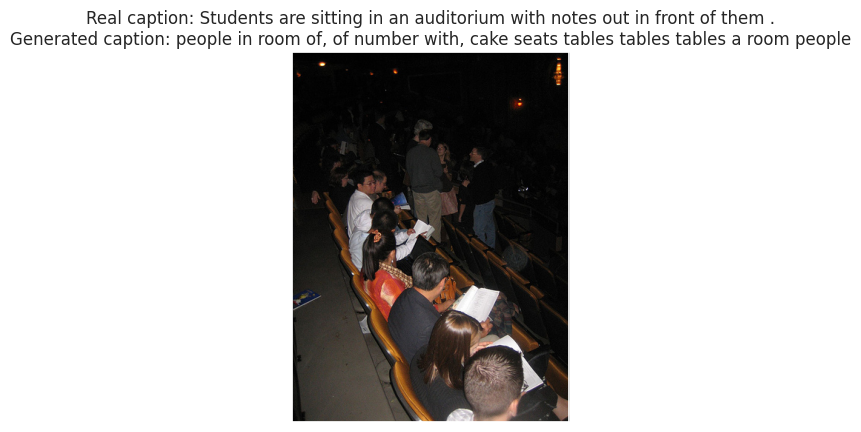

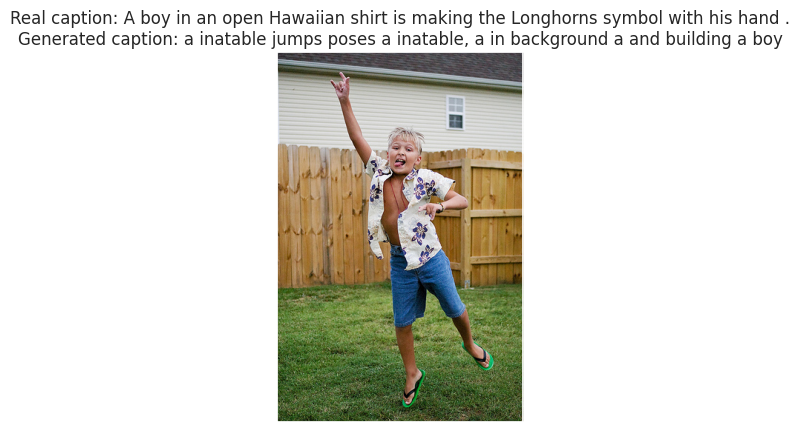

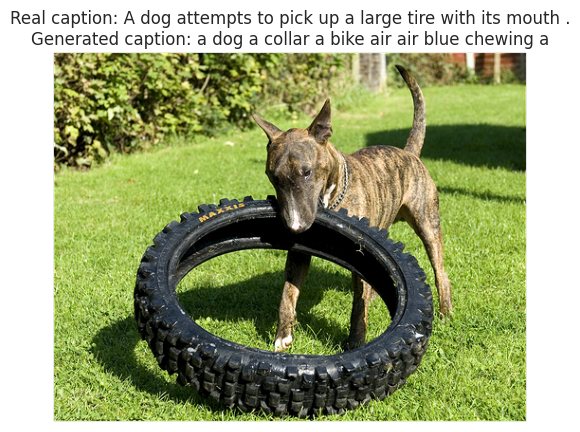

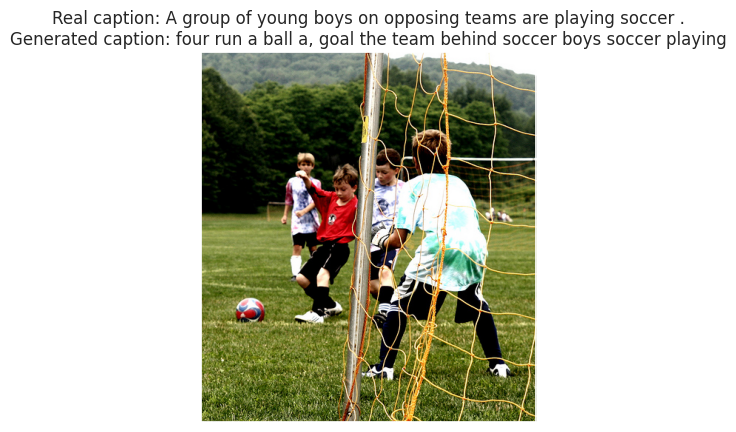

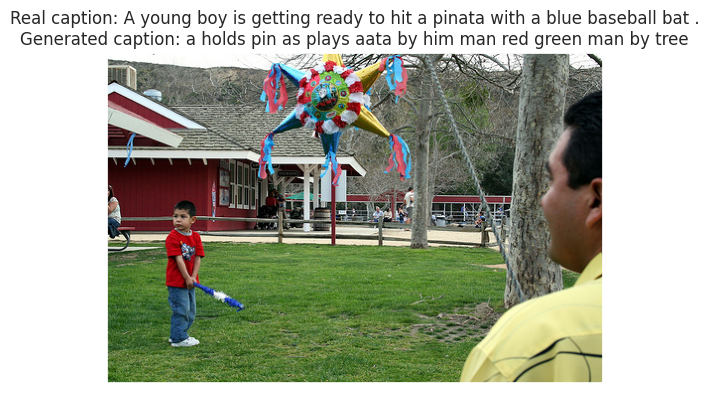

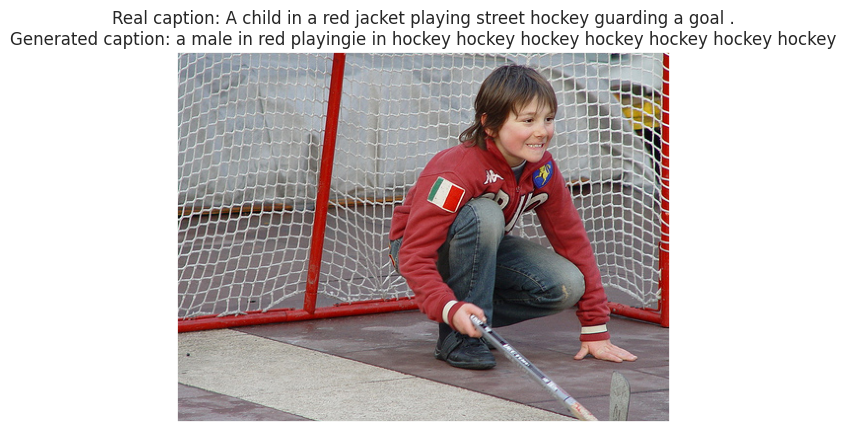

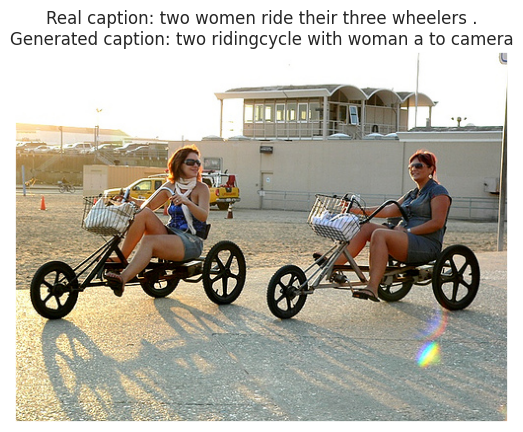

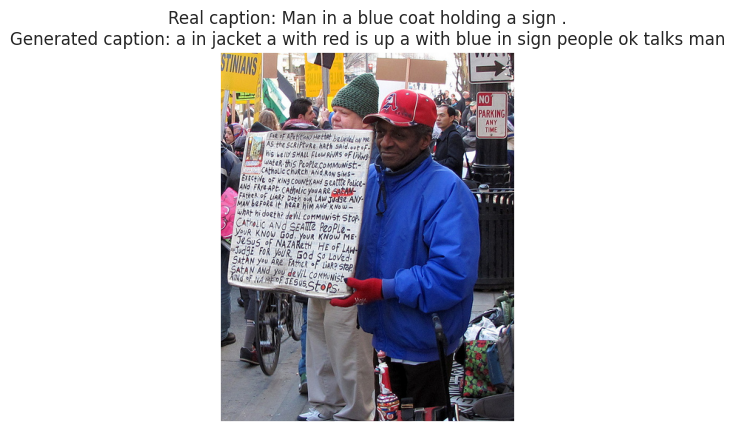

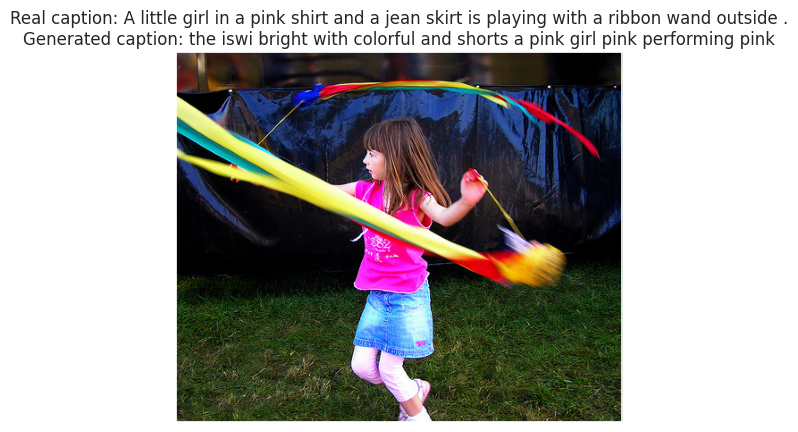

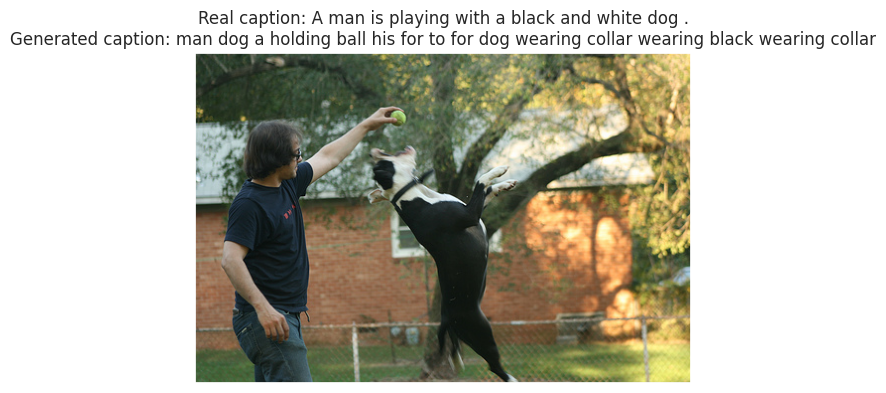

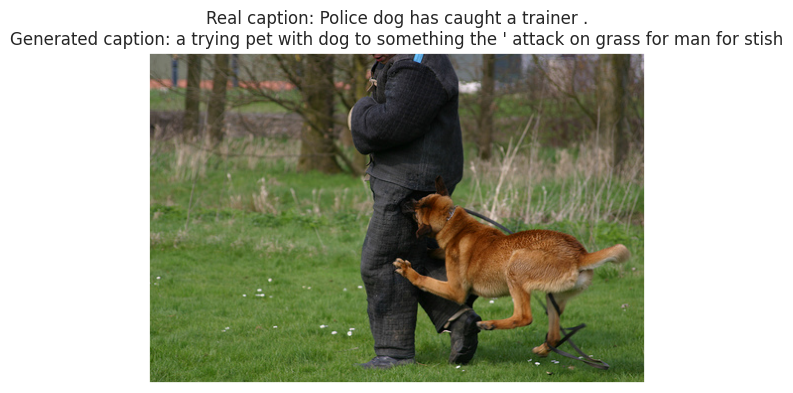

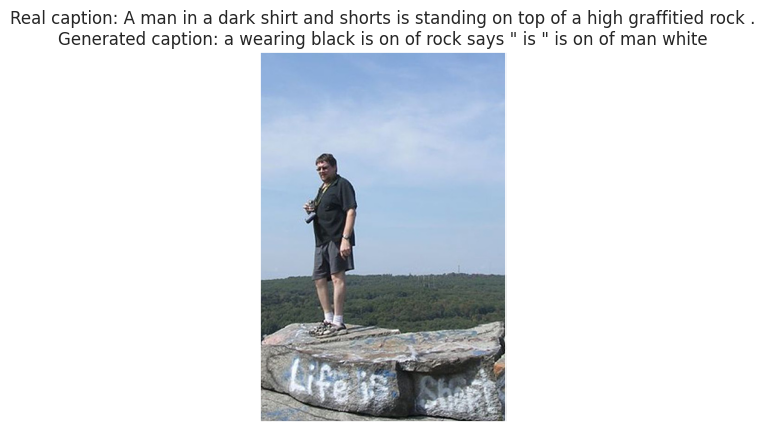

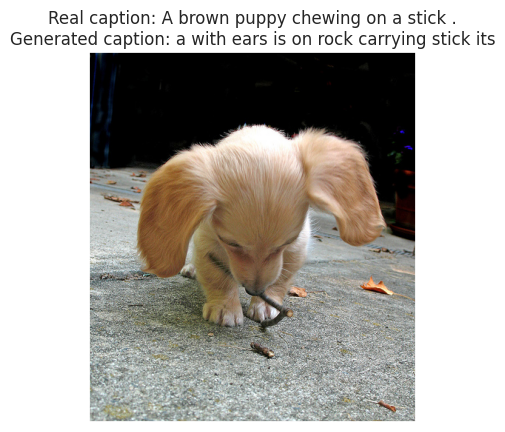

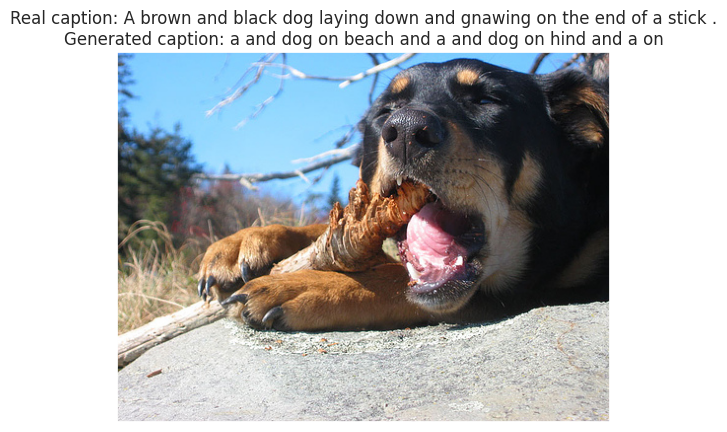

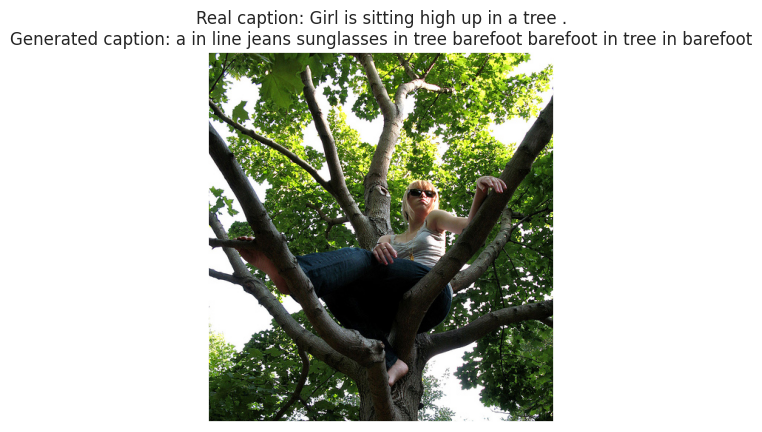

In [ ]:
for i in ids:
    pixel_values = valid_ds[i][0].unsqueeze(0).to(device)
    predictions = tokenizer.decode(model.generate(pixel_values=pixel_values)[0], skip_special_tokens=True)
    fact = valid_df.loc[int(i), 'caption']
    caption = predictions.replace('.', '').strip()

    im = plt.imread(valid_df.iloc[i].image)
    title = f'Real caption: {fact}\nGenerated caption: {caption}'

    plt.imshow(im)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

It looks like the model can capture the content of the images in most cases, but the generated captions contain many mistakes. This confusion likely stems from the model being trained on four different captions for each image. It would be interesting to see if training the model with only one caption per image.

**Conclusions:**

- Model can capture the content on the images
- Cpations are not natural because of different captions for a single image
- It would be a good idea to train a model with one caption for each image for the 1st experiment and one caption for each image in ~6000 images and remaining 2000 for the test and the validation sets.